In [1]:
#meta 4/15/2021 myClassify (multiclass) for LSHTC - Train model with fast.ai
# task: classify text (multiclass) 
# input: data/lshtc3_wikipedia_med_df_train_tidy.pkl
#      LSHTC3 reduced ds with less labels
#      Important reset index - fast.ai dataloaders don't like a gap in index
#      to avoid -> TypeError: 'float' object is not iterable

#task: Multi-category text classification - supervise
#based on 1_classify_sentiment_spacy_multi.ipynb


#history
#      4/15/2021 FAST.AI in AML
#      Accuracy ~61% 
#      4/19/2021 TRY FAST.AI in Kaggle 
#      Accuracyimproves by ~1%


In [2]:
%matplotlib inline
#import time as time #to track performance time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump


In [3]:
from fastai.text.all import *

In [4]:
#declare vars
SEED = 24

# LSHTC: Classify Text 
Train text classifier using Transfer Learning.  2 steps:  
1. fine-tune our language model pretrained on Wikipedia to the corpus of Expeditors survey  
2. use that model to train a classifier  



## 0. Load Data
input: a prepared pickle with pre-selected relevant fields.

In [5]:
df_tidy = load('/kaggle/input/mylshtc3train/lshtc3_wikipedia_med_df_train_tidy.pkl') 
print(df_tidy.shape)
print(df_tidy.columns)
print(df_tidy.dtypes)
df_tidy.head()


(151800, 2)
Index(['labels', 'text'], dtype='object')
labels    category
text        object
dtype: object


,labels,text
0,130762,"Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University."
1,352578,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran..."
2,395447,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran..."
3,27512,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran..."
4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981) was a pioneering Canadian-born American motion picture director, producer and screenwriter."


In [6]:
#clean df
df = df_tidy[['text', 'labels']].copy()
df.columns = ['text', 'label']

#reset index - dataloaders don't like a gap in index
#to fix error in next cell: TypeError: 'float' object is not iterable
#df.reset_index(drop=True, inplace=True)

df.head(2)

,text,label
0,"Alain Connes (born 1 April 1947) is a French mathematician, currently Professor at the Coll\u00E8ge de France, IH\u00C9S and Vanderbilt University.",130762
1,"Ayn Rand (born Alisa Zinov'yevna Rosenbaum; February 2 1905 – March 6, 1982), was a Russian-American novelist, philosopher, playwright, and screenwriter. She is known for her two best-selling novels and for developing a philosophical system she called Objectivism. Born and educated in Russia, Rand immigrated to the United States in 1926. She worked as a screenwriter in Hollywood and had a play produced on Broadway in 1935\u20131936. She first achieved fame in 1943 with her novel The Fountainhead, which in 1957 was followed by her best-known work, the philosophical novel Atlas Shrugged. Ran...",352578


## 1. Data Prep for fast.ai
Prepare our data for the language model and for the classification model separately, using fast.ai library.

### 1.1 Data Prep for Language Model Using DataBlock
fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. `DataBlock`'s handy `summary` method is useful for debugging data issues.


Putting Our Texts into Batches for a Language Model

In [7]:
#src https://docs.fast.ai/text.data.html#TextDataLoaders.from_df
#dls_lm = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, valid_col='is_valid')
dls_lm = TextDataLoaders.from_df(df, text_col='text', is_lm=True, valid_pct = 0.15, splitter=RandomSplitter(valid_pct = 0.15, seed = SEED)) 
dls_lm.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj tinley xxmaj park is a village located primarily in xxmaj cook xxmaj county , xxmaj illinois , xxmaj united xxmaj states with a small portion in xxmaj will xxmaj county . xxmaj the population was xxunk at the 2 xxrep 3 0 census , and xxunk in the 2007 census . xxmaj it is one of the fastest growing suburbs south of xxmaj chicago . xxmaj in 2009 , xxmaj","xxmaj tinley xxmaj park is a village located primarily in xxmaj cook xxmaj county , xxmaj illinois , xxmaj united xxmaj states with a small portion in xxmaj will xxmaj county . xxmaj the population was xxunk at the 2 xxrep 3 0 census , and xxunk in the 2007 census . xxmaj it is one of the fastest growing suburbs south of xxmaj chicago . xxmaj in 2009 , xxmaj tinley"
1,"states until age thirteen when he was sent to a breeding operation in xxmaj argentina . xxmaj he was not successful as a sire . xxbos xxmaj merlin xxmaj jay xxmaj olsen ( september 15 , 1940 \ u2013 xxmaj march 11 , 2010 ) was a former xxmaj american football player in the xxmaj national xxmaj football xxmaj league and an actor . xxmaj he played his entire 15-year career with","until age thirteen when he was sent to a breeding operation in xxmaj argentina . xxmaj he was not successful as a sire . xxbos xxmaj merlin xxmaj jay xxmaj olsen ( september 15 , 1940 \ u2013 xxmaj march 11 , 2010 ) was a former xxmaj american football player in the xxmaj national xxmaj football xxmaj league and an actor . xxmaj he played his entire 15-year career with the"
2,- old - feuds - die - hard 2 http : / / query . nytimes . com / gst / xxunk . xxunk 3 http : / / xxunk . xxunk . com / ? s = devine 4 http : / / xxunk . xxunk . com 5 http : / / xxrep 3 w . xxunk . com / matt - friedman / xxunk / elizabeth - old -,old - feuds - die - hard 2 http : / / query . nytimes . com / gst / xxunk . xxunk 3 http : / / xxunk . xxunk . com / ? s = devine 4 http : / / xxunk . xxunk . com 5 http : / / xxrep 3 w . xxunk . com / matt - friedman / xxunk / elizabeth - old - feuds


In [8]:
#dataset dims
len(dls_lm.train_ds), len(dls_lm.valid_ds)

(129030, 22770)

In [12]:
#view vocab, class list
print("LM vocab size: ", len(dls_lm.vocab))
dls_lm.vocab[5:100]

LM vocab size:  60008


['xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 'the',
 '.',
 'in',
 'and',
 'of',
 'a',
 'was',
 'he',
 'is',
 'to',
 '-',
 ')',
 '(',
 'for',
 '"',
 'his',
 'as',
 'on',
 'an',
 'at',
 'with',
 "'s",
 'by',
 'american',
 'from',
 'born',
 '\\',
 'she',
 'new',
 'film',
 'also',
 'has',
 'her',
 'it',
 'who',
 'that',
 '3',
 'first',
 'york',
 'known',
 'which',
 'one',
 'university',
 'united',
 'states',
 'after',
 'played',
 'national',
 'county',
 '2',
 'best',
 'city',
 '0',
 'two',
 'had',
 'league',
 'during',
 "'",
 'hockey',
 'school',
 'years',
 'career',
 'world',
 'california',
 ';',
 'time',
 'where',
 'been',
 'work',
 'professional',
 ':',
 'member',
 'john',
 'this',
 'but',
 'most',
 '1',
 'canadian',
 'won',
 'television',
 'series',
 'were',
 '/',
 'including',
 'became',
 'former',
 'football',
 'award',
 'when',
 'year']

In [10]:
mystop

NameError: name 'mystop' is not defined

Data is ready, we can fine-tune the pretrained language model.

## 2. Model
The LM was pretrained on Wikipedia.  Fine-tune this LM to Expeditors survey corpus, and then use that as the base for our classifier.  
![ULMFiT Process](my-images/ch10_ULMFIT_process.png)
### 2.1 Fine-Tuning the Language Model


In [13]:
#class fastai.text.learner.LMLearner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

0.005754 1e-06


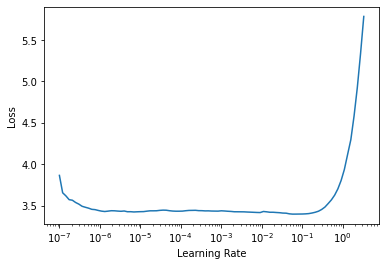

In [14]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [15]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.885147,2.762524,0.477897,15.839778,25:47


In [16]:
#save and load models
learn.save('1epoch')
#learn = learn.load('1epoch')

Path('models/1epoch.pth')

In [17]:
learn = learn.load('1epoch')

Once the initial training has completed, continue fine-tuning the model after unfreezing

In [18]:
learn.unfreeze()
learn.fit_one_cycle(5, 4e-3) 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.711045,2.747078,0.477900,15.596990,27:55
1,2.648863,2.652518,0.491781,14.189717,28:34
2,2.464705,2.538101,0.507217,12.655621,28:41
3,2.301499,2.449042,0.520628,11.577254,28:37
4,2.138474,2.435082,0.524448,11.416759,28:39


In [19]:
#save model encoder
learn.save_encoder('finetuned')

In [20]:
#class fastai.text.learner.LMLearner
#learn.summary()

##### Text generation

In [21]:
TEXT = "I would recommend Expeditors because"
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

In [22]:
print("\n".join(preds))

i would recommend Xxunk because it was the first American film to be filmed . It was the first film for Warner Brothers . It starred Edward Everett Horton , Anne Bancroft , Paul
i would recommend Xxunk because of the fact that it was the only time it saw I 'm not known to be involved in the relationship between the American public and the Vatican . Jay Marshall ( born


This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### 1.2 Data Prep for Classifier Model Using DataBlock
Creating the Classifier DataLoaders

In [23]:
dls_clf = TextDataLoaders.from_df(df, text_col='text', label_col='label', vocab=dls_lm.vocab, valid_pct = 0.25, splitter=RandomSplitter(0.25, seed = SEED))
dls_clf.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj aristides xxmaj burton xxmaj demetrios ( born 1932 ) was born and raised in xxmaj massachusetts . xxmaj his father , xxmaj george xxmaj demetrios , was a classical sculptor , trained by xxmaj xxunk , a student of xxmaj rodin . xxmaj his mother , xxmaj virginia xxmaj lee xxmaj burton was the renowned author and illustrator of children 's books , including xxmaj mike xxmaj mulligan and xxmaj his xxmaj steam xxmaj shovel , and xxmaj the xxmaj little xxmaj house , for which she won the prestigious xxmaj caldecott prize . xxmaj after graduating from xxmaj harvard xxmaj college , xxmaj mr . xxmaj demetrios spent three years as an officer in the xxmaj navy and then studied at the xxmaj george xxmaj demetrios xxmaj school for three years . xxmaj in 1963 , he won his first national sculpture competition when his proposed design",135508
1,"xxbos xxmaj john xxmaj henry xxmaj tunstall ( 6 xxmaj march 1853 – 18 xxmaj february 1878 ) was a xxmaj new xxmaj mexican rancher and prominent figure in the xxmaj lincoln xxmaj county xxmaj war . xxmaj born in xxmaj xxunk , xxmaj london , xxmaj england . xxmaj tunstall emigrated to xxmaj victoria , xxmaj british xxmaj columbia , xxmaj canada in 1872 where he spent his time working at xxmaj turner , xxmaj xxunk & xxmaj tunstall , a store in which his father was a partner . xxmaj tunstall left xxmaj canada for the xxmaj united xxmaj states in xxmaj february 1876 . xxmaj he spent six months investigating the possibility of becoming a sheep rancher in xxmaj california , but decided instead to try xxmaj new xxmaj mexico , where land was cheaper and more abundant for ranching . xxmaj soon after his arrival in",333275
2,"xxbos xxmaj charles xxmaj hazlitt xxmaj cahan , xxup k.c . , xxup p.c . ( october 31 , xxunk 15 , 1944 ) was a prominent xxmaj canadian lawyer , newspaper editor , businessman , and provincial and federal politician . a xxmaj presbyterian of xxmaj irish descent and born in xxmaj hebron , xxmaj nova xxmaj scotia , son of xxmaj charles xxmaj cahan xxmaj jr . ( 1838 - 1908 ; irish - scottish ancestry , who was the son of xxmaj charles xxmaj cahan xxmaj sr . and xxmaj jennie xxmaj hazlitt ) , and xxmaj theresa ( flint ) xxmaj cahan ( 1838 - 1918 ; xxmaj new xxmaj england ancestry ) . xxmaj siblings included xxmaj frank xxup d. xxmaj cahan ( 1863 - 1936 ) , xxmaj jennie xxup m. xxmaj cahan ( 1866 - 1918 ) and xxmaj xxunk xxup s. xxmaj",242897


In [24]:
len(dls_clf.train_ds), len(dls_clf.valid_ds)

(113850, 37950)

### 2.2 Model Classifier

In [25]:
#class fastai.text.learner.TextLearner
learn = text_classifier_learner(dls_clf, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Prior to training the classifier, load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded

In [26]:
learn = learn.load_encoder('finetuned')

##### Fine-tune classifier
The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference

0.036308 0.069183


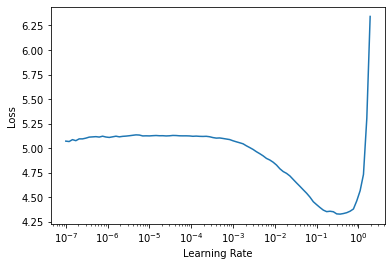

In [27]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [28]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.691185,1.508438,0.579552,05:51


In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.503214,1.386722,0.606614,06:20


Unfreeze more and train

In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.444235,1.344448,0.617049,07:53


Finally, the whole model

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.466698,1.335658,0.618946,09:27
1,1.369687,1.331409,0.620026,09:26


We reached 69% accuracy. 

Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them. This is exciting stuff!

In [32]:
#learn.summary()
learn.show_results()

,text,category,category_
0,"xxbos xxmaj richard xxmaj wright xxmaj nowels xxmaj jr . xxmaj rick xxmaj nowels is a xxmaj grammy / xxmaj ivor xxmaj novello award winning songwriter / producer who has worked with many of the most vibrant artists in contemporary music . xxmaj beginning with his number one worldwide hit single , \ xxunk xxmaj is a xxmaj place on xxmaj earth \ u201d by xxmaj belinda xxmaj carlisle in 1987 xxmaj rick has since co - written over 60 top 20 singles . xxmaj his songs have appeared on over 200 million albums . xxmaj he is a multi - instrumentalist ( guitar , keyboards , bass ) who incorporates contemporary sounds and rhythms within classic songwriting . xxmaj rick has written with or had his songs recorded by the following artists : xxmaj madonna , xxmaj dido , xxmaj john xxmaj legend / xxmaj andre 3 xxrep 3",78599,78599
1,"xxbos xxmaj the xxmaj show of xxmaj shows is a lavish revue film which cost $ 850 , xxrep 3 0 and featured most of the contemporary xxmaj warner xxmaj bros . film stars . xxmaj it was styled in the same format as the earlier xxup mgm film xxmaj the xxmaj hollywood xxmaj revue of 1929 . xxmaj photographed almost entirely in xxmaj technicolor , the cost of the film meant that although it performed well at the box office , it did not return as much profit as the xxup mgm film . xxmaj seen today in incomplete black and white xxunk prints , it remains of historical interest , showing the talent working at xxmaj warner xxmaj bros . in the early talkie period . xxmaj the film features all the stars then working at xxmaj warner xxmaj bros . except for xxmaj dorothy xxmaj mackaill and",167593,167593
2,"xxbos xxmaj robert xxmaj keith xxmaj leavitt ( xxunk ) was a xxmaj harvard - educated xxmaj new xxmaj york xxmaj city advertising copywriter who turned to non - fiction writing . xxmaj he was the author of many books , including a history of xxmaj webster 's xxmaj dictionary and "" the xxmaj chip on xxmaj grandma 's xxmaj shoulder "" ( 1954 . ) ' bob ' xxmaj leavitt was also the longtime historian of the original xxmaj baker xxmaj street xxmaj irregulars , devoted to all things xxmaj xxunk , about which he wrote in his "" the xxmaj origins of xxunk xxmaj worship . "" xxmaj leavitt was born on xxmaj august 20 , 1895 , in xxmaj cambridge , xxmaj massachusetts , to xxmaj dr . xxmaj robert xxmaj greenleaf xxmaj leavitt , a xxmaj harvard - trained botanist , researcher , author and later",283823,289056
3,"xxbos xxmaj charlie xxmaj van xxmaj dyke ( born xxmaj charles xxmaj leo xxmaj xxunk , on xxmaj december 19 , 1947 ) is a former radio disc jockey who is better known for the voice work he has done for numerous radio and television stations . xxmaj his deep , booming voice has been described by some as "" god - like "" . a native of xxmaj dallas , xxmaj texas , he was already one of xxmaj america 's most respected radio personalities at xxup klif - am in xxmaj dallas when he was only 19 years old . xxmaj during the 1970s , xxmaj van xxmaj dyke was the morning xxup dj at several legendary xxmaj top 40 stations , including xxup cklw in xxmaj windsor / xxmaj detroit , xxup khj xxmaj los xxmaj angeles , xxup kfrc xxmaj san xxmaj francisco , xxup wls",286463,286463
4,"xxbos xxmaj emily xxmaj cissy xxmaj drinkard xxmaj houston ( born xxmaj september 30 , 1933 ) , better known as xxmaj cissy xxmaj houston , is a xxmaj grammy xxmaj award winning xxmaj american soul and gospel singer . xxmaj she led a very successful career as a backup singer for such artists as xxmaj elvis xxmaj presley , xxmaj mahalia xxmaj jackson , and xxmaj aretha xxmaj franklin , and is now primarily a solo artist . xxmaj she is the mother of singer and actress xxmaj whitney xxmaj houston and aunt of xxmaj dionne xxmaj warwick and the late xxmaj dee xxmaj dee xxmaj warwick . xxmaj born in xxmaj newark , xxmaj new xxmaj jersey , xxmaj houston was the youngest of eight children of parents xxmaj nicholas ( aka xxmaj xxunk ) and xxmaj delia 

In [33]:
#save final model
learn.save('clf_final')
#export model as pkl
learn.export()

## 3. Model Evaluation
src https://docs.fast.ai/interpret.html#ClassificationInterpretation  
src code https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L51
### 3.1 Report and Confusion Matrix

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

       10088       0.76      0.88      0.81       250
       10307       0.46      0.26      0.33       115
       10590       0.44      0.18      0.26       212
       13139       0.79      0.18      0.29       167
       14661       0.47      0.29      0.35       263
       14902       0.99      1.00      0.99       225
       16954       1.00      0.99      1.00       128
       21411       0.99      1.00      1.00       171
       23214       0.99      0.98      0.99       185
       27512       0.59      0.80      0.68       127
       29931       0.33      0.46      0.38       181
       37462       0.41      0.23      0.30       125
       38982       0.29      0.51      0.37       197
       43724       0.50      0.61      0.55       205
       47471       0.79      0.96      0.87       232
       47886       0.53      0.06      0.11       258
       48448       0.94      0.97      0.95       289
       51347       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


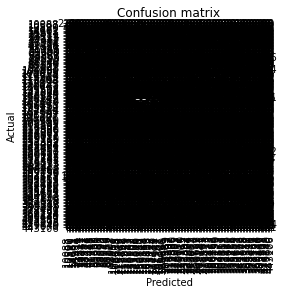

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [42]:
interp.most_confused(min_val = 100)

[(231362, 167593, 245),
 (47886, 167593, 222),
 (283823, 352578, 196),
 (169463, 352578, 146),
 (308993, 93043, 142),
 (88179, 167593, 139),
 (390846, 395447, 127),
 (14661, 347803, 119),
 (167593, 229765, 111),
 (126647, 417577, 110),
 (403289, 219680, 106)]

In [37]:
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"xxbos xxmaj jeffrey "" jeff "" xxmaj nero xxmaj hardy ( born xxmaj august 31 , 1977 ) is an xxmaj american professional wrestler , currently signed to xxmaj total xxmaj nonstop xxmaj action xxmaj wrestling ( tna ) . xxmaj he is best known for his time in the xxmaj world xxmaj wrestling xxmaj federation / xxmaj entertainment ( wwe ) . xxmaj before gaining prominence in xxup wwe , xxmaj hardy performed for the xxmaj organization of xxmaj modern xxmaj extreme xxmaj grappling xxmaj arts ( omega ) , a promotion he ran with his brother xxmaj matt . xxmaj after being signed by xxup wwe , the brothers worked as xxunk , before gaining notoriety in the tag team division , partly due to their participation in xxmaj tables , xxmaj ladders , and xxmaj chairs matches . xxmaj with the addition of xxmaj lita , the",135508,229071,0.7470338940620422,13.486957550048828
1,"xxbos xxmaj kenneth xxmaj wallace ( born xxmaj august 23 , 1963 ) is a xxup nascar xxmaj sprint xxmaj cup xxmaj series and xxmaj nationwide xxmaj series driver who currently drives the # 28 xxmaj united xxmaj states xxmaj border xxmaj patrol xxmaj chevrolet xxmaj impala xxup ss for xxmaj jay xxmaj robinson xxmaj racing in the xxup nascar xxmaj nationwide xxmaj series . xxmaj he also works as an on - air personality for xxmaj speed xxmaj channel , on shows such as xxup nascar raceday and xxup nascar xxmaj victory xxmaj lane . xxmaj he was also featured on the show on xxup fx . xxmaj he has two brothers who are also xxup nascar drivers : now retired older brother xxmaj rusty xxmaj wallace and superspeedway specialist xxmaj mike xxmaj wallace , as well as a nephew xxmaj steve xxmaj wallace who races in the xxmaj",195307,257731,0.9983820915222168,12.442537307739258
2,xxbos xxmaj pinky xxmaj mitchell was an xxmaj american boxer who was the first champion in the light welterweight division .,13139,177784,0.9992708563804626,12.23412799835205
3,"xxbos xxmaj michael xxmaj oates xxmaj palmer ( born in 1974 ) is an xxmaj american screenwriter , television writer , and producer . xxmaj he wrote on xxmaj the xxmaj west xxmaj wing , xxmaj army xxmaj wives , xxmaj blind xxmaj justice , and xxmaj shark , and most recently was a writer - producer on xxmaj cupid .",297190,395447,0.8650602102279663,12.004819869995117
4,"xxbos xxmaj edward xxmaj andrew xxmaj schultz ( born xxmaj january 27 , 1954 ) is an xxmaj american television and radio host and political pundit . xxmaj he is the host of xxmaj the xxmaj ed xxmaj show , a daily news program on xxup msnbc , and xxmaj the xxmaj ed xxmaj schultz xxmaj show , a nationally syndicated talk radio show promising "" straight talk . """,184027,286463,0.49454209208488464,11.938497543334961
5,"xxbos xxmaj richard xxmaj fiske ( november 20 , 1915 - xxmaj august 10 , 1944 ) was an xxmaj american film actor . xxmaj he appeared in over 80 films between 1938 and 1942 .",335885,106615,0.3207279443740845,11.871537208557129
6,"xxbos xxmaj al xxmaj xxunk ( born 1932 ) is an xxmaj american journalist , award - winning author , editor , lecturer , historian and golfer .",219680,284433,0.7452427744865417,11.745217323303223
7,"xxbos xxmaj joseph xxmaj xxunk xxmaj xxunk ( 30 xxmaj july 1896 – 1982 ) was a xxmaj liberal party member of the xxmaj canadian xxmaj house of xxmaj commons . xxmaj he was born in xxmaj chicago , xxmaj illinois , xxmaj united xxmaj states and moved to xxmaj canada in 1907 . xxmaj xxunk attended school at xxmaj watson , xxmaj saskatchewan then studied at the xxmaj agricultural xxmaj college in xxmaj fargo , xxmaj north xxmaj dakota . xxmaj he became a farmer by career , a municipal councillor from 1929 to 1932 and a school trustee from 1931 to 1943 . xxmaj he was first elected to xxmaj parliament at the xxmaj humboldt riding in the 1949 general election . xxmaj after serving one term in the xxmaj house of xxmaj commons , the xxmaj humboldt riding had been disbanded and xxmaj xxunk campaigned at the",30466

#### 4. Predict

In [54]:
learn_inf = load_learner('/kaggle/working/export.pkl')
learn_inf.predic("text goes here"))

ModuleAttributeError: 'SequentialRNN' object has no attribute 'predic'

In [ ]:
mystop

## $Xtra. Data Prep for ML


In [ ]:
#interested in words in all rows, column 0
#this text_train
X = df['FINAL_COMMENT'].copy()
X.shape


In [ ]:
#for supervised learning
y = df['Q_NPS_CAT'].copy()
print(y.shape)
y.head()


In [ ]:
print(y.value_counts().sort_index())
y.value_counts().sort_index().plot(kind="bar")

In [ ]:
import fastai
from fastai import *
from fastai.text import *

#from IPython.display import display,HTML 

In [ ]:
#$was
# use TextBlock to create a language model, pass TextBlock to DataBlock
#es_lm = DataBlock(
#    blocks=TextBlock.from_df('text', seq_len=72, is_lm=True),
##    #get_x=ColReader('text'), 
#    splitter=RandomSplitter(0.2, seed = SEED)) 

#dataloaders
#dls_lm = es_lm.dataloaders(df['text'], bs=64)
#dls_lm.show_batch(max_n=2)

In [ ]:
#src https://forums.fast.ai/t/the-interpretation-of-text-classification-throws-an-error-when-used-on-a-pretrained-network/39471
def show_piece_attn(*args, **kwargs):
    from IPython.display import display, HTML
    display(HTML(piece_attn_html(*args, **kwargs)))

def _eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): _eval_dropouts(module)
            
class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`. """

In [ ]:
#https://github.com/fastai/fastai/pull/2115/files
#from fastai.train import ClassificationInterpretation

#from fastai.data.all import *
from fastai.basic_train import Learner #fastai v1 is not compatible vith v2
from fastai.vision import DatasetType


__all__ = ['TextClassificationInterpretation']

print(fastai.DatasetType.valid)

class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        _eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output + (torch.zeros_like(ids).byte(),))[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

    def html_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->str:
        text, attn = self.intrinsic_attention(text, class_id)
        return piece_attn_html(text.text.split(), to_np(attn), **kwargs)

    def show_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->None:
        text, attn = self.intrinsic_attention(text, class_id)
        show_piece_attn(text.text.split(), to_np(attn), **kwargs)

    def show_top_losses(self, k:int, max_len:int=70)->None:
        """
        Create a tabulation showing the first `k` texts in top_losses along with their prediction, actual,loss, and probability of
        actual class. `max_len` is the maximum number of tokens displayed.
        """
        from IPython.display import display, HTML
        items = []
        tl_val,tl_idx = self.top_losses()
        for i,idx in enumerate(tl_idx):
            if k <= 0: break
            k -= 1
            tx,cl = self.data.dl(self.ds_type).dataset[idx]
            cl = cl.data
            classes = self.data.classes
            txt = ' '.join(tx.text.split(' ')[:max_len]) if max_len is not None else tx.text
            tmp = [txt, f'{classes[self.pred_class[idx]]}', f'{classes[cl]}', f'{self.losses[idx]:.2f}',
                   f'{self.preds[idx][cl]:.2f}']
            items.append(tmp)
        items = np.array(items)
        names = ['Text', 'Prediction', 'Actual', 'Loss', 'Probability']
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False))) 

In [ ]:
learn.model

In [ ]:
for m in learn.model.modules():
    print('--')
    print(m)